# <div style="text-align: center">Causal Discovery - Examples</div>

<div style="text-align: justify">The following are some simple examples that try to explain the working of some of the code functionalities in this repository.</div>

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from GraphUtils import *
from ConditionalIndependenceTest import *

### 1. Conditional-Independence Criterion <br>

<div style="text-align: justify">The Conditional-Independence test applied while estimating the skeleton structure of the underlying causal model is based on Decision Tree Regressors.</div><br>
<div style="text-align: justify">It is a non-parametric, fast conditional independence test that is based on the following intuition : <br>
    
<i>"For any conditioning set Z, if the combined predictive capability of X and Z to predict Y is better than the predictive capability of Z to predict Y, then X contains useful information about Y. This means that X and Y cannot be guaranteed to be conditionally independent, given Z." </i></div><br>

<div style="text-align: justify"> This test and therefore the code used to implement this test is based on the work: <b><i>" Fast Conditional Independence Test for Vector Variables with Large Sample Sizes "</b></i> by Krzysztof Chalupka et al.
<a href="https://arxiv.org/pdf/1804.02747.pdf"> (Link here) </a><br>

In [2]:
                    # simple examples of FCIT implemented in code #

Z = np.empty((10000, 0))

# X1 and Y1 are not independent
X1 = np.random.rand(10000, 1)
Y1 = 0.3*np.random.rand(10000, 1)+X1
print('Are X1 and Y1 conditionally independent, given Z ? : {}'.format\
      (test_conditional_independence(X1, Y1, Z, verbose=True)))

# X2 and Y2 are independent
print()
X2 = np.random.rand(10000, 1)
Y2 = np.random.rand(10000, 1)
print()
print('Are X2 and Y2 conditionally independent, given Z ? : {}'.format\
      (test_conditional_independence(X2, Y2, Z, verbose=True)))

p-value for the null hypothesis that X and Y are conditionally independent, given Z : 5.710554720210552e-10
Are X1 and Y1 conditionally independent, given Z ? : False


p-value for the null hypothesis that X and Y are conditionally independent, given Z : 0.846917612957562
Are X2 and Y2 conditionally independent, given Z ? : True


<b>NOTE</b>: <i>For more details about the specific test-related p-values, please refer the code.</i>

### 2. Causal structure Learning<br>
<div style="text-align: justify">The procedure for structure learning is as follows: </div>
<ul>
    <li>The skeleton is estimated as in the stable PC-algorithm, by applying the Fast Conditional-Independence Test (described above) as the Independence Criterion.</li>
    <li>The undirected edges in the skeleton graph are then oriented based on the following logic : For any two nodes X and Y, with an undirected edge between them, in the skeletal graph, if score = A(regression:Y=f(X)) - A(regression:X=f(Y)) > 0, then, on average, Y contains relatively more information useful for predicting X. Therefore, the edge is oriented Y-->X and X-->Y otherwise. Each edge has a weight = mean(scores) <br> <b>NOTE</b>: 'A' is the accuracy of a regression model and the score is computed for several repeated runs and then averaged. </li>
    <li>The cycles in the Directed Graph are then removed based on the heuristic : For any cycle in the graph, the edge with the lowest weight is reversed and if possible, removed.
    </li>
</ul>
Finally, the algorithm outputs a Directed Acyclic Graph representing the Causal Model of the observational data. 

<b>IMPORTANT NOTES</b> : <i>As with any Causal Discovery algorithms, this algorithm must be treated as a first-step to causal discovery as opposed to a complete, and fully reliable causal inference method.</i>

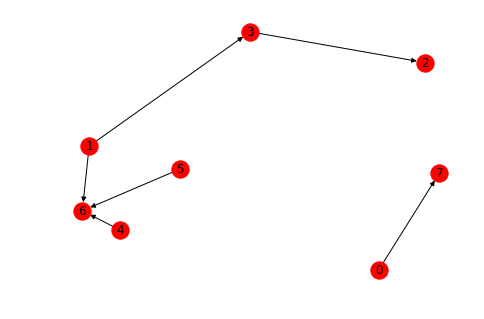

In [5]:
# EXAMPLE OBSERVATIONAL DATA WITH CONDITIONAL DEPENDENCIES AMONG FEATURES
data = np.zeros(shape=(10000, 8))
data[:, 0] = np.random.normal(loc=10.0, scale=5.0, size=10000)
data[:, 1] = np.random.normal(loc=1.0, scale=2.0, size=10000)
data[:, 2] = np.random.gamma(2, 0.65, 10000)
data[:, 3] = data[:, 1] + data[:, 2]
data[:, 4] = np.random.beta(0.8, 0.65, 10000)
data[:, 5] = np.random.beta(0.1, 0.05, 10000)
data[:, 6] = data[:, 1] * data[:, 4] - data[:, 5]
data[:, 7] = data[:, 0]
data = pd.DataFrame(data, columns=['0', '1', '2', '3', '4', '5', '6', '7'])
causal_graph = infer_DAG(data, orientation_model='Tree')
nx.draw(causal_graph, with_labels=True)
plt.show()

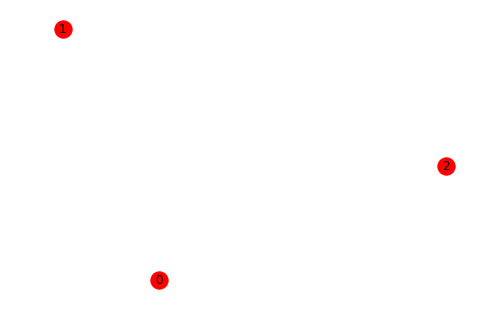

In [6]:
# EXAMPLE OBSERVATIONAL DATA WITHOUT ANY (CONDITIONAL) DEPENDENCIES AMONG FEATURES
data = np.zeros(shape=(10000, 3))
data[:, 0] = np.random.normal(loc=10.0, scale=5.0, size=10000)
data[:, 1] = np.random.beta(0.01, 0.9, size=10000)
data[:, 2] = np.random.gamma(2, 0.65, 10000)
data = pd.DataFrame(data, columns=['0', '1', '2'])
causal_graph = infer_DAG(data, orientation_model='Tree')
nx.draw(causal_graph, with_labels=True)
plt.show()

<div style="text-align: justify"> The algorithm further builds a collection of Deep Neural Networks on a learned Causal Graphical Model. Each node has a corresponding Neural Network as a function approximator for the function X = f(Noise, Parents(X)). Hence, the input to any node is now a function of the outputs of the Neural Networks of it's parent nodes and some random noise. The result is a Data Generation Mechanism that exploits a Causal Structure to model interventions. The Network will be trained by generating data and updating the weights based on the gradients of the Max-Mean Discrepancy between observed data and generated data. Due to computational reasons, such a network has not been included in this notebook. However, code implementation in tensorflow is available in this repository.</div><br>
 
<div style="text-align: justify"> How to model interventions? <br>
    
   Well, for any <i>do-Variable</i>, the corresponding node-neural-network in the graph is shut down and then generated data can be analyzed to observe how the joint distribution of other variables change.</div><br>
  
<div style="text-align: justify"> This collective Neural Network is based on the research paper : <b><i>"Learning Functional Causal Models with Generative Neural Networks"</b></i> by Diviyan Kalainathan et al. <a href="https://arxiv.org/pdf/1709.05321.pdf"> (Link here) </a><br></div><br>